# Calculating averages and standard deviations

Purpose:
--------
The purpose of this notebook is to calculate averages and standard deviations for the configuration file used to train CGnet for machine learning detection of atmospheric rivers and tropical cyclones.\
See ClimateNet repo here: https://github.com/andregraubner/ClimateNet

Authors/Contributors:
---------------------
* Teagan King
* John Truesdale
* Katie Dagon

## Import libraries

In [9]:
import xarray as xr
import numpy as np

### Set up Dask

In [5]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem='5GB' # specify memory here so it duplicates below
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/$USER/local_dask', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem, # Specify resources
    account='P93300313', # Input your project ID here, previously this was known as 'project', now is 'account'
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [7]:
client

<Client: 'tcp://10.12.206.48:41603' processes=10 threads=10, memory=46.60 GiB>

## Set file paths

In [8]:
# original training data from NERSC
file_path = "/glade/campaign/cgd/amp/jet/ClimateNet_12012020/portal.nersc.gov/project/ClimateNet/climatenet_new/train/"

## Set relevant variables used for training

In [3]:
variables = ["TMQ", "U850", "V850", "PSL"]

## Open training data

In [13]:
#cnet = xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folder+cnet_files, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)
ds = xr.open_mfdataset(file_path+"*.nc", concat_dim='time', combine='nested', parallel=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 398)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-1996-06-09-01-1.nc' ... 'data-2010-10-29-01-...
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    UBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    VBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    QREFHT   (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    ...       ...
    TS       (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    TREFHT   (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    Z1000    (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    Z200     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    ZBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    LABELS   (time, lat, lon) int64 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>

## Testing workflow

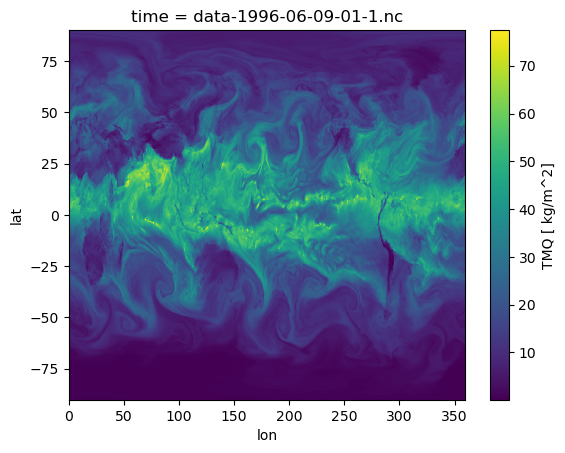

In [15]:
# first time index TMQ plot
ds.TMQ.isel(time=0).plot();

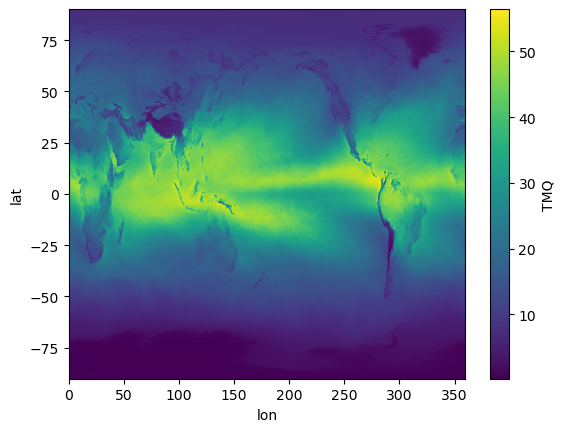

In [17]:
# time mean TMQ test plot
ds.TMQ.mean(dim='time').plot();

In [20]:
# weighted global mean
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

In [24]:
# test TMQ global mean of time mean
TMQ_weighted = ds.TMQ.mean(dim='time').weighted(weights)
TMQ_weighted_mean = TMQ_weighted.mean(("lon", "lat"))
TMQ_weighted_mean.values

array(24.92723817)

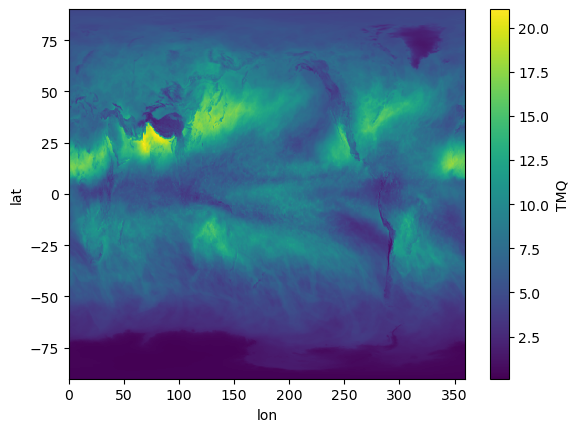

In [28]:
# time std TMQ test plot
ds['TMQ'].std(dim='time').plot();

In [29]:
# test TMQ global mean of time std - is this the right calculation?
TMQ_weighted_std = ds['TMQ'].std(dim='time').weighted(weights)
TMQ_weighted_std_mean = TMQ_weighted_std.mean(('lon', 'lat'))
TMQ_weighted_std_mean.values

array(7.48674837)

## Function to calculate weighted global mean and standard deviation

In [39]:
def wgt_mean_std(var):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    
    var_wgt_mean = ds[var].mean(dim='time').weighted(weights).mean(("lon", "lat")).compute()
    
    var_wgt_std = ds[var].std(dim='time').weighted(weights).mean(("lon", "lat")).compute()
    
    return(var_wgt_mean, var_wgt_std)

## Calculate values

In [40]:
all_means = []
all_std = []
for var in variables:
    means, std = wgt_mean_std(var)
    all_means.append(means)
    all_std.append(std)

In [45]:
for i, var in enumerate(variables):
    print("{} mean: {}".format(var, all_means[i].values))
    print("{} std: {}".format(var, all_std[i].values))

TMQ mean: 24.927238169017997
TMQ std: 7.486748366124207
U850 mean: 1.0356735863118816
U850 std: 5.607192208082629
V850 mean: 0.20847854977498861
V850 std: 4.944376413217935
PSL mean: 101095.03520124489
PSL std: 632.6919364866603


## For reference: the previous method of calculating means/std yielded these values
These are quite different (especially the stds) so we should figure out a consistent method.

In [117]:
for var in variables:
    final_mean_var = np.mean(all_means[var])
    print("{} mean: {}".format(var, final_mean_var))
    final_std_var = np.mean(all_stds[var])
    print("{} std: {}".format(var, final_std_var))

TMQ mean: 19.21849250793457
TMQ std: 15.731818702352706
U850 mean: 1.5530235767364502
U850 std: 8.277896973355931
V850 mean: 0.2541317343711853
V850 std: 6.2159415082116825
PSL mean: 100814.0703125
PSL std: 1454.369694542046
